<a href="https://colab.research.google.com/github/khalilDimassi/Datasci_Resources/blob/master/5thYearAIproject_v0_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [60]:
!pip install -q networkx nltk gensim PyMuPDF transformers huggingface_hub spark-nlp pyspark sentence-transformers levenshtein

In [62]:
import fitz
import re
import networkx as nx
import pandas as pd

import nltk
nltk.download('stopwords')
import nltk.corpus
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords

from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
import gensim
from gensim.models import LdaModel
from gensim.corpora import Dictionary

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [68]:
def extract_text_from_pdf(file_path, start=1, finish=None):
    with fitz.open(file_path) as doc:
        text = ''
        for i in range(start-1, finish or len(doc)):
            page = doc.load_page(i)
            text += page.get_text()
        return text


def clean_text(text):
    text = re.sub(r'[^\x00-\x7F]+|\n|\t|[^\w\s]|\d', '', text)
    text = re.sub(r'uu', '', text)
    return text


def standardize_text(text):
  return text.lower()

def stem_text(text):
  stemmer = PorterStemmer()
  words = text.split()
  stemmed_words = [stemmer.stem(word) for word in words]
  return stemmed_words

def remove_stop_words(stemmed_words, custom_stop_words=None):
  stop_words = set(stopwords.words('english'))
  if custom_stop_words is not None:
    stop_words.update(custom_stop_words)
  filtered_words = [word for word in stemmed_words if word not in stop_words]
  return filtered_words

def autocorrect_text(text):
  # Initialize the tokenizer
  tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
  # Initialize the model
  model = AutoModelForSeq2SeqLM.from_pretrained('facebook/bart-large')

  # Encode the cleaned text
  encoded_text = tokenizer(text, return_tensors='pt')
  # Generate the autocorrected text
  generated_text = model.generate(encoded_text)
  # Decode the generated text and return the autocorrected text
  corrected_text = tokenizer.decode(generated_text[0], skip_special_tokens=True)

  return corrected_text

def lda_segmentation(documents):
  dictionary = Dictionary(documents)
  corpus = [dictionary.doc2bow(text) for text in documents]
  model = LdaModel(corpus, num_topics=10, id2word=dictionary, passes=15)
  topic_distributions = model.get_document_topics(corpus)
  dominant_topics = [max(topic_distribution, key=topic_distribution.get) for topic_distribution in topic_distributions]

  # Segment the text at the boundaries between topic changes
  segments = []
  current_topic = dominant_topics[0]
  current_segment = []
  for i in range(len(documents)):
    if dominant_topics[i] != current_topic:
      segments.append(current_segment)
      current_segment = []
    current_segment.append(documents[i])
  segments.append(current_segment)

  return segments

def create_graph_from_pairs(pairs, threshold=0.5):
    graph = nx.Graph()

    # Add a node for each sentence
    for sentence, embedding in pairs.items():
        node_id = len(graph)
        graph.add_node(node_id, features=embedding)

    # Add edges between the nodes based on their similarity
    for node_id1 in range(len(graph)):
        for node_id2 in range(node_id1 + 1, len(graph)):
            similarity = 1 - np.dot(graph.nodes[node_id1]['features'], graph.nodes[node_id2]['features']) / (
                    np.linalg.norm(graph.nodes[node_id1]['features']) * np.linalg.norm(graph.nodes[node_id2]['features']))
            if similarity > threshold:
                graph.add_edge(node_id1, node_id2, weight=similarity)

    return graph


In [64]:
text = extract_text_from_pdf("/content/PMBOK ch11.pdf", start=3)

ListData = []

# Define the regular expression pattern
pattern = r'11\.\d+\.\d+ [A-Z][^\n]*'

# Find all matches
matches = re.finditer(pattern, text)

for match in matches:
    # Get the matched title
    title = match.group(0).strip()

    # Find the start and end positions of the matched title
    start = match.start()
    end = match.end()

    # Find the content following the matched title
    content_start = end
    next_match = re.search(pattern, text[end:])

    if next_match:
        # If a next match is found, extract its start position
        content_end = end + next_match.start()
    else:
        # If no next match is found, use the end of the text
        content_end = len(text)

    # Extract the content (paragraph) for this title
    content = text[content_start:content_end].strip()

    # Create a tuple (title, content) and append it to ListData
    couple = (title, content)
    ListData.append(couple)
    print("Title:" , title.strip())
    print("Content:", content)
    print("---\n")


df = pd.DataFrame(ListData, columns=['title', 'Body'])

Title: 11.1.1 PLAN RISK MANAGEMENT: INPUTS
Content: 11.1.1.1 PROJECT CHARTER
Described in Section 4.1.3.1. The project charter documents the high-level project description and boundaries, high-
level requirements, and risks.
Not For Distribution, Sale or Reproduction.
403
11.1.1.2 PROJECT MANAGEMENT PLAN
Described in Section 4.2.3.1. In planning Project Risk Management, all approved subsidiary management plans 
should be taken into consideration in order to make the risk management plan consistent with them. The methodology 
outlined in other project management plan components might inﬂuence the Plan Risk Management process.
11.1.1.3 PROJECT DOCUMENTS
Project documents that can be considered as inputs for this process include but are not limited to the stakeholder 
register as described in Section 13.1.3.1. The stakeholder register contains details of the project’s stakeholders and 
provides an overview of their project roles and their attitude toward risk on this project. This is usef

In [39]:
df

,title,Body
0,11.1.1 PLAN RISK MANAGEMENT: INPUTS,11.1.1.1 PROJECT CHARTER\nDescribed in Section...
1,11.1.2 PLAN RISK MANAGEMENT: TOOLS AND TECHNIQUES,11.1.2.1 EXPERT JUDGMENT\nDescribed in Section...
2,11.1.3 PLAN RISK MANAGEMENT: OUTPUTS,11.1.3.1 RISK MANAGEMENT PLAN\nThe risk manage...
3,11.2.1 IDENTIFY RISKS: INPUTS,11.2.1.1 PROJECT MANAGEMENT PLAN\nDescribed in...
4,11.2.2 IDENTIFY RISKS: TOOLS AND TECHNIQUES,11.2.2.1 EXPERT JUDGMENT\nDescribed in Section...
5,11.2.3 IDENTIFY RISKS: OUTPUTS,11.2.3.1 RISK REGISTER\nThe risk register capt...
6,11.3.1 PERFORM QUALITATIVE RISK ANALYSIS: INPUTS,11.3.1.1 PROJECT MANAGEMENT PLAN\nDescribed in...
7,11.3.2 PERFORM QUALITATIVE RISK ANALYSIS: TOOL...,11.3.2.1 EXPERT JUDGMENT\nDescribed in Section...
8,11.3.3 PERFORM QUALITATIVE RISK ANALYSIS: OUTPUTS,11.3.3.1 PROJECT DOCUMENTS UPDATES\nProject do...
9,11.4.1 PERFORM QUANTITATIVE RISK ANALYSIS: INPUTS,11.4.1.1 PROJECT MANAGEMENT PLAN\nDescribed in...


In [40]:
from pyspark.sql import SparkSession
from sparknlp.base import *
from sparknlp.annotator import *
from sparknlp.pretrained import PretrainedPipeline
import sparknlp

spark = sparknlp.start()

In [41]:
from sparknlp.base import DocumentAssembler
from sparknlp.annotator import SentenceDetectorDLModel
from pyspark.ml import Pipeline

# load df into sparkdf
spark_df = spark.createDataFrame(df)

documentAssembler = DocumentAssembler().setInputCol("Body").setOutputCol("document")
sentenceDetectorDL = SentenceDetectorDLModel.pretrained("sentence_detector_dl", "en").setInputCols(["document"]).setOutputCol("sentences")

pipeline = Pipeline(stages=[
    documentAssembler,
    sentenceDetectorDL
])

sentence_detector_dl download started this may take some time.
Approximate size to download 354.6 KB
[OK!]


In [42]:
model = pipeline.fit(spark_df)
result = model.transform(spark_df)
result_df = result.toPandas()
result_df['sentences_array'] = result_df['sentences'].apply(lambda x: [i['result'] for i in x])
result_df


,title,Body,document,sentences,sentences_array
0,11.1.1 PLAN RISK MANAGEMENT: INPUTS,11.1.1.1 PROJECT CHARTER\nDescribed in Section...,"[(document, 0, 1930, 11.1.1.1 PROJECT CHARTER\...","[(document, 0, 23, 11.1.1.1 PROJECT CHARTER, {...","[11.1.1.1 PROJECT CHARTER, Described in Sectio..."
1,11.1.2 PLAN RISK MANAGEMENT: TOOLS AND TECHNIQUES,11.1.2.1 EXPERT JUDGMENT\nDescribed in Section...,"[(document, 0, 1503, 11.1.2.1 EXPERT JUDGMENT\...","[(document, 0, 23, 11.1.2.1 EXPERT JUDGMENT, {...","[11.1.2.1 EXPERT JUDGMENT, Described in Sectio..."
2,11.1.3 PLAN RISK MANAGEMENT: OUTPUTS,11.1.3.1 RISK MANAGEMENT PLAN\nThe risk manage...,"[(document, 0, 11393, 11.1.3.1 RISK MANAGEMENT...","[(document, 0, 28, 11.1.3.1 RISK MANAGEMENT PL...","[11.1.3.1 RISK MANAGEMENT PLAN, The risk manag..."
3,11.2.1 IDENTIFY RISKS: INPUTS,11.2.1.1 PROJECT MANAGEMENT PLAN\nDescribed in...,"[(document, 0, 5966, 11.2.1.1 PROJECT MANAGEME...","[(document, 0, 31, 11.2.1.1 PROJECT MANAGEMENT...","[11.2.1.1 PROJECT MANAGEMENT PLAN, Described i..."
4,11.2.2 IDENTIFY RISKS: TOOLS AND TECHNIQUES,11.2.2.1 EXPERT JUDGMENT\nDescribed in Section...,"[(document, 0, 7480, 11.2.2.1 EXPERT JUDGMENT\...","[(document, 0, 23, 11.2.2.1 EXPERT JUDGMENT, {...","[11.2.2.1 EXPERT JUDGMENT, Described in Sectio..."
5,11.2.3 IDENTIFY RISKS: OUTPUTS,11.2.3.1 RISK REGISTER\nThe risk register capt...,"[(document, 0, 7403, 11.2.3.1 RISK REGISTER\nT...","[(document, 0, 21, 11.2.3.1 RISK REGISTER, {'s...","[11.2.3.1 RISK REGISTER, The risk register cap..."
6,11.3.1 PERFORM QUALITATIVE RISK ANALYSIS: INPUTS,11.3.1.1 PROJECT MANAGEMENT PLAN\nDescribed in...,"[(document, 0, 2050, 11.3.1.1 PROJECT MANAGEME...","[(document, 0, 31, 11.3.1.1 PROJECT MANAGEMENT...","[11.3.1.1 PROJECT MANAGEMENT PLAN, Described i..."
7,11.3.2 PERFORM QUALITATIVE RISK ANALYSIS: TOOL...,11.3.2.1 EXPERT JUDGMENT\nDescribed in Section...,"[(document, 0, 9742, 11.3.2.1 EXPERT JUDGMENT\...","[(document, 0, 23, 11.3.2.1 EXPERT JUDGMENT, {...","[11.3.2.1 EXPERT JUDGMENT, Described in Sectio..."
8,11.3.3 PERFORM QUALITATIVE RISK ANALYSIS: OUTPUTS,11.3.3.1 PROJECT DOCUMENTS UPDATES\nProject do...,"[(document, 0, 5261, 11.3.3.1 PROJECT DOCUMENT...","[(document, 0, 33, 11.3.3.1 PROJECT DOCUMENTS ...","[11.3.3.1 PROJECT DOCUMENTS UPDATES, Project d..."
9,11.4.1 PERFORM QUANTITATIVE RISK ANALYSIS: INPUTS,11.4.1.1 PROJECT MANAGEMENT PLAN\nDescribed in...,"[(document, 0, 3817, 11.4.1.1 PROJECT MANAGEME...","[(document, 0, 31, 11.4.1.1 PROJECT MANAGEMENT...","[11.4.1.1 PROJECT MANAGEMENT PLAN, Described i..."


In [43]:
def clean_sentences(sentences):
    cleaned_sentences = []
    for sentence in sentences:
        cleaned = clean_text(sentence)
        cleaned = standardize_text(cleaned)
        cleaned = stem_text(cleaned)
        cleaned = remove_stop_words(cleaned, custom_stop_words=('uu'))
        # cleaned = autocorrect_text(cleaned)
        cleaned_sentences.append(' '.join(cleaned))
    return cleaned_sentences


In [44]:
result_df['cleaned_sentences'] = result_df['sentences_array'].apply(clean_sentences)

In [45]:
result_df['cleaned_sentences'][0]

['project charter',
 'describ section',
 'project charter document highlevel project descript boundari highlevel requir risk',
 'distribut sale reproduct',
 'project manag plan',
 'describ section',
 'plan project risk manag approv subsidiari manag plan taken consider order make risk manag plan consist',
 'methodolog outlin project manag plan compon might inuenc plan risk manag process',
 'project document',
 'project document consid input thi process includ limit stakehold regist describ section',
 'stakehold regist contain detail project stakehold provid overview project role attitud toward risk thi project',
 'thi use determin role respons manag risk project well set risk threshold project',
 'enterpris environment factor',
 'enterpris environment factor inuenc plan risk manag process includ limit overal risk threshold set organ key stakehold',
 'organiz process asset',
 'organiz process asset inuenc plan risk manag process includ limit organiz risk polici risk categori possibl orga

In [46]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer('all-MiniLM-L6-v2')

In [47]:
# Apply the model to each list of sentences
result_df['embeddings'] = result_df['cleaned_sentences'].apply(model.encode)
result_df['embeddings']

0     [[-0.0055071055, -0.016203228, 0.0012083447, -...
1     [[0.014457368, 0.05019053, -0.05944085, -0.000...
2     [[0.024670057, 0.099616535, -0.010794415, -0.0...
3     [[-0.021513017, 0.08314721, 0.047742784, -0.01...
4     [[0.014457368, 0.05019053, -0.05944085, -0.000...
5     [[-0.037950084, -0.0651553, -0.10360649, -0.01...
6     [[-0.021512998, 0.08314721, 0.047742777, -0.01...
7     [[0.014457368, 0.05019053, -0.05944085, -0.000...
8     [[-0.11397704, 0.05593008, -0.076104715, -0.03...
9     [[-0.021512998, 0.08314721, 0.047742777, -0.01...
10    [[0.014457368, 0.05019053, -0.05944085, -0.000...
11    [[-0.113977045, 0.055930078, -0.07610472, -0.0...
12    [[-0.021512998, 0.08314721, 0.047742777, -0.01...
13    [[0.014457368, 0.05019053, -0.05944085, -0.000...
14    [[-0.08921557, 0.006100853, 0.022027202, 0.006...
15    [[-0.021512998, 0.08314721, 0.047742777, -0.01...
16    [[0.014457368, 0.05019053, -0.05944085, -0.000...
17    [[-0.089215584, 0.006100857, 0.022027222, 

In [48]:
# Flatten the sentences and embeddings into separate lists
all_sentences = [sentence for sentences in result_df['cleaned_sentences'] for sentence in sentences]
all_embeddings = [embedding for embeddings in result_df['embeddings'] for embedding in embeddings]

In [49]:
import numpy as np
import matplotlib.pyplot as plt

def levenshtein_distance(s1, s2):
    """Calculates the Levenshtein distance between two strings."""

    # Create a matrix to store the Levenshtein distances.
    matrix = np.zeros((len(s1) + 1, len(s2) + 1))

    # Initialize the first row and column of the matrix.
    for i in range(len(s1) + 1):
        matrix[i, 0] = i
    for j in range(len(s2) + 1):
        matrix[0, j] = j

    # Calculate the Levenshtein distances for the remaining cells in the matrix.
    for i in range(1, len(s1) + 1):
        for j in range(1, len(s2) + 1):
            if s1[i - 1] == s2[j - 1]:
                matrix[i, j] = matrix[i - 1, j - 1]
            else:
                matrix[i, j] = min(matrix[i - 1, j] + 1, matrix[i, j - 1] + 1, matrix[i - 1, j - 1] + 1)

    # Return the Levenshtein distance between the two strings.
    return matrix[len(s1), len(s2)]

In [50]:
from Levenshtein import distance as levenshtein_distance

# Initialize an empty list to store the distances
distances = []

# Iterate over all pairs of sentences
for i in range(len(all_sentences)):
    for j in range(i+1, len(all_sentences)):
        # Calculate the Levenshtein distance between the two sentences
        distance = levenshtein_distance(all_sentences[i], all_sentences[j])
        # Append the distance to the list
        distances.append(distance)


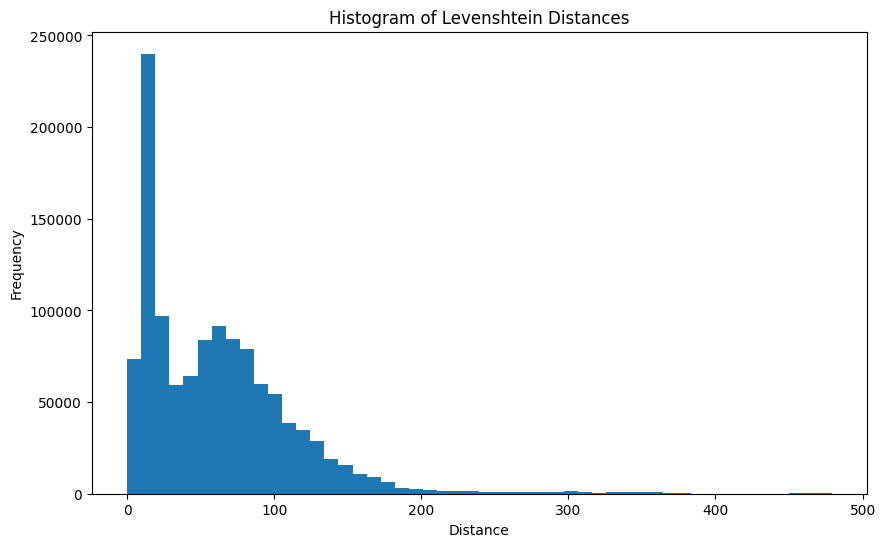

In [51]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.hist(distances, bins=50)
plt.title('Histogram of Levenshtein Distances')
plt.xlabel('Distance')
plt.ylabel('Frequency')
plt.show()


<ipython-input-52-3c0968246c88>:4: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(distances, shade=True)


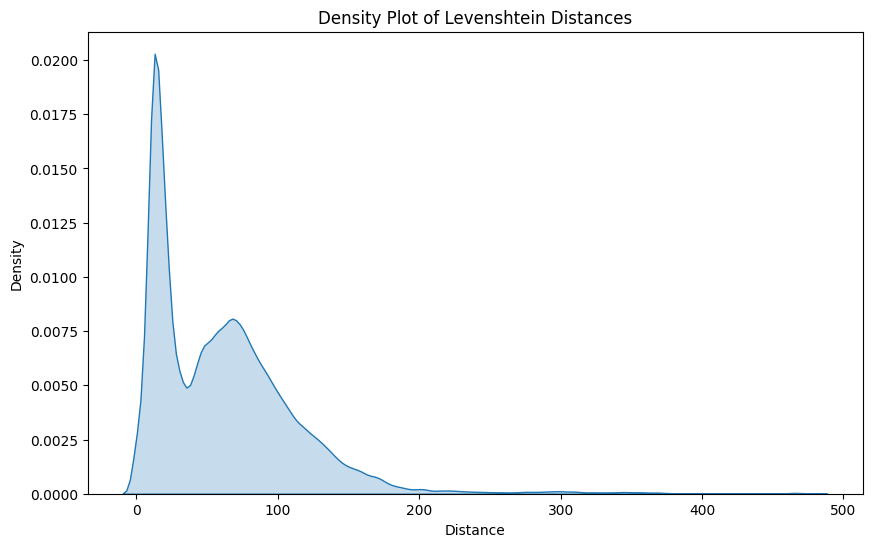

In [52]:
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.kdeplot(distances, shade=True)
plt.title('Density Plot of Levenshtein Distances')
plt.xlabel('Distance')
plt.ylabel('Density')
plt.show()


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

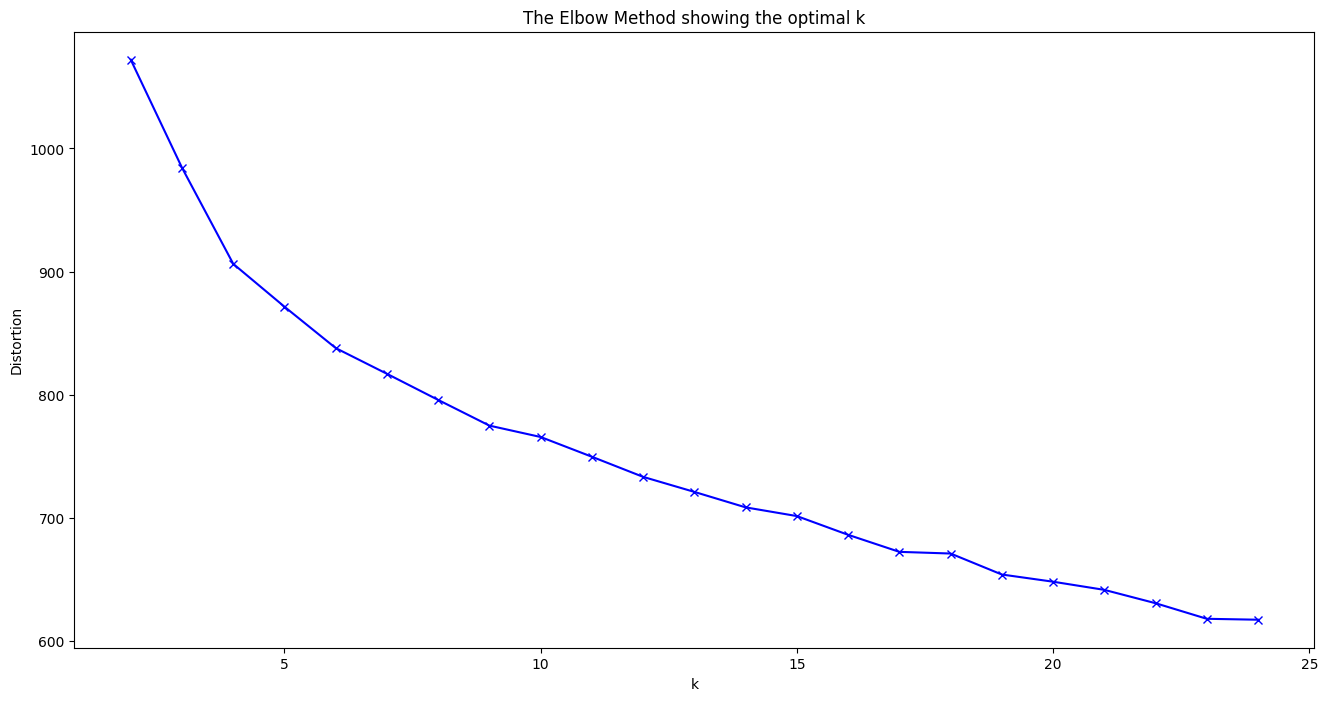

In [54]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

distortions = []
K = range(2, 25)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(all_embeddings)
    distortions.append(kmeanModel.inertia_)

plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()


In [57]:
sentence_embedding_pairs = {}
for sentence, embedding in zip(all_sentences, all_embeddings):
  sentence_embedding_pairs[sentence] = embedding

In [69]:
# create the graph:
graph = create_graph_from_pairs(sentence_embedding_pairs)

In [ ]:
degree_centrality = nx.degree_centrality(graph)
betweenness_centrality = nx.betweenness_centrality(graph)
closeness_centrality = nx.closeness_centrality(graph)

In [74]:
laplacian_matrix = nx.laplacian_matrix(graph)
eigenvalues = nx.algebraic_connectivity(graph)

In [75]:
eigenvalues

297.1384155389115